## 1. Load data

In [30]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset 
from functools import partial

import fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

import transformers
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, BertConfig
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig, AdamW

import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, roc_curve, f1_score

In [9]:
print(torch.__version__)

2.2.1+cu121


In [10]:
raw = pd.read_csv('tsla_dataset.csv', encoding='utf-8', names=['Date', 'News_Headline','label','score'])
raw['label'].replace({'neutral':'Neutral', 'positive':'Positive', 'negative': 'Negative'}, inplace=True)
raw

,Date,News_Headline,label,score
0,Date,Content,label,final_score
1,2020-12-31,Tesla short sellers lost billions more on the ...,Negative,0.9986944794654846
2,2020-12-29,"In 2021, the breadth of the competitive attack...",Positive,0.7760137915611267
3,2020-12-28,"In 2021, the breadth of the competitive attack...",Positive,0.7760137915611267
4,2020-12-25,Elon Musk says it’s “impossible” to take Tesla...,Neutral,0.9448846280574799
...,...,...,...,...
8961,2015-02-16,Apple has assigned hundreds of staffers to an ...,Neutral,0.9942009150981903
8962,2015-02-16,Apple gears up to challenge Tesla in electric ...,Neutral,0.9961254298686981
8963,2015-02-13,Apple has assigned 100s of staffers to an elec...,Neutral,0.9995115399360657
8964,2015-01-28,"Apple, Microsoft and Tesla shops are helping h...",Neutral,0.8085040748119354


In [11]:
raw = raw.drop(raw.index[0])
raw

,Date,News_Headline,label,score
1,2020-12-31,Tesla short sellers lost billions more on the ...,Negative,0.9986944794654846
2,2020-12-29,"In 2021, the breadth of the competitive attack...",Positive,0.7760137915611267
3,2020-12-28,"In 2021, the breadth of the competitive attack...",Positive,0.7760137915611267
4,2020-12-25,Elon Musk says it’s “impossible” to take Tesla...,Neutral,0.9448846280574799
5,2020-12-25,Elon Musk has made millionaires out of Tesla's...,Neutral,0.7669579684734344
...,...,...,...,...
8961,2015-02-16,Apple has assigned hundreds of staffers to an ...,Neutral,0.9942009150981903
8962,2015-02-16,Apple gears up to challenge Tesla in electric ...,Neutral,0.9961254298686981
8963,2015-02-13,Apple has assigned 100s of staffers to an elec...,Neutral,0.9995115399360657
8964,2015-01-28,"Apple, Microsoft and Tesla shops are helping h...",Neutral,0.8085040748119354


## 2. Prepare Dataset for Fine-tuning

In [12]:
raw2 = raw.copy()
raw2['label'].replace({'Neutral':0, 'Positive':1, 'Negative':2}, inplace=True)
raw2 = raw2[['Date', 'News_Headline','label','score']]
raw2

,Date,News_Headline,label,score
1,2020-12-31,Tesla short sellers lost billions more on the ...,2,0.9986944794654846
2,2020-12-29,"In 2021, the breadth of the competitive attack...",1,0.7760137915611267
3,2020-12-28,"In 2021, the breadth of the competitive attack...",1,0.7760137915611267
4,2020-12-25,Elon Musk says it’s “impossible” to take Tesla...,0,0.9448846280574799
5,2020-12-25,Elon Musk has made millionaires out of Tesla's...,0,0.7669579684734344
...,...,...,...,...
8961,2015-02-16,Apple has assigned hundreds of staffers to an ...,0,0.9942009150981903
8962,2015-02-16,Apple gears up to challenge Tesla in electric ...,0,0.9961254298686981
8963,2015-02-13,Apple has assigned 100s of staffers to an elec...,0,0.9995115399360657
8964,2015-01-28,"Apple, Microsoft and Tesla shops are helping h...",0,0.8085040748119354


In [13]:
seed = 2024

In [14]:
df_train, df_test, = train_test_split(raw2, stratify=raw2['label'], test_size=0.1, random_state=seed)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'], test_size=0.1, random_state=seed)
print(df_train.shape, df_test.shape, df_val.shape)

(7261, 4) (897, 4) (807, 4)


## 3. Prepare the Final Test Dataset

In [15]:
val_set = df_val.copy()
test_set = df_test.copy()
test_set = pd.concat([test_set, val_set], axis=0) # 把test和val concat起來
test_set.reset_index(inplace=True, drop = True)
test_set['label'].replace({0:'Neutral', 1:'Positive', 2:'Negative'}, inplace=True)
test_set

,Date,News_Headline,label,score
0,2017-08-04,5 comparably priced alternatives to Tesla's Mo...,Neutral,0.9908865690231323
1,2020-02-27,New Tesla car registrations in China plunge 46...,Negative,0.9983943402767181
2,2015-05-24,"The burger chain that's ""Tesla for burgers,"" a...",Neutral,0.9995343387126923
3,2019-01-02,At least one analyst is flagging the Tesla sel...,Negative,0.997196465730667
4,2019-09-13,Toyota using Tesla-style Panasonic batteries f...,Neutral,0.9996406435966492
...,...,...,...,...
1699,2020-09-22,Elon Musk reaffirms Tesla's forecast that the ...,Positive,0.9989539384841918
1700,2019-01-10,Tesla may offer a Roadster option where the ca...,Neutral,0.9994813203811646
1701,2020-11-17,Tesla value set to jump $40 billion as S&amp;P...,Positive,0.9990701973438263
1702,2017-05-11,"Tesla just released solar roof prices, and the...",Positive,0.9974154233932495


In [16]:
print(test_set.shape)

(1704, 4)


## 4. Exploratory Data Analytics

In [17]:
def frequency_length(df, column_name, figsize = (10, 6)):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # clear_output()
    sequence_token_lengths = []

    for headline in df[column_name]:
        encoded_headline = tokenizer.encode(headline, add_special_tokens=True) # 將每個頭條文本轉換成一個分詞ID序列，並且包含了特殊分詞
        # record the length of the encoded review
        sequence_token_lengths.append(len(encoded_headline))

    # Get the percentage of headlines with length > 512
    # 篩選出所有長度大於512的頭條，因為BERT模型的輸入長度限制為512分詞
    len_512_plus = [head_len for head_len in sequence_token_lengths if head_len > 512]
    percent = (len(len_512_plus)/len(sequence_token_lengths)) * 100

    print('Facts:')
    print("1. Number of Sequences With Greater Than 512 Tokens: {}".format(len(len_512_plus)))
    print("2. Maximum Sequence Length: {} Tokens".format(max(sequence_token_lengths)))
    print("3. Average Sequence Length: {} Tokens".format(np.average(sequence_token_lengths).round(1)))

    # Configure the plot size
    plt.figure(figsize = figsize)
    sns.set(style='darkgrid')
    # Plot the result
    sns.displot(sequence_token_lengths, kde = False, rug = False)
    plt.title("Distribution of Sequences' Lengths")
    plt.xlabel("Sequences' Length")
    plt.ylabel('Number of Sequences')

Facts:
1. Number of Sequences With Greater Than 512 Tokens: 0
2. Maximum Sequence Length: 80 Tokens
3. Average Sequence Length: 22.9 Tokens


<Figure size 1000x600 with 0 Axes>

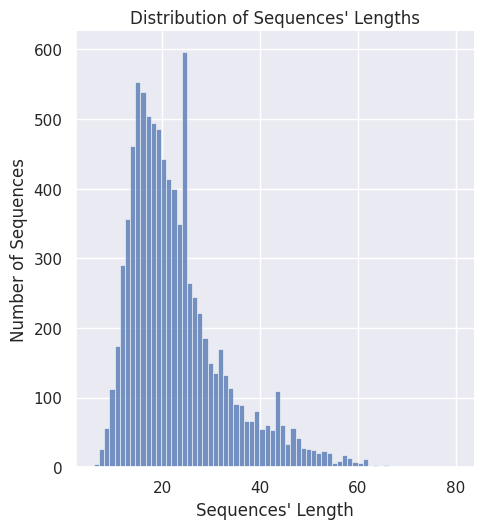

In [18]:
frequency_length(raw, 'News_Headline')

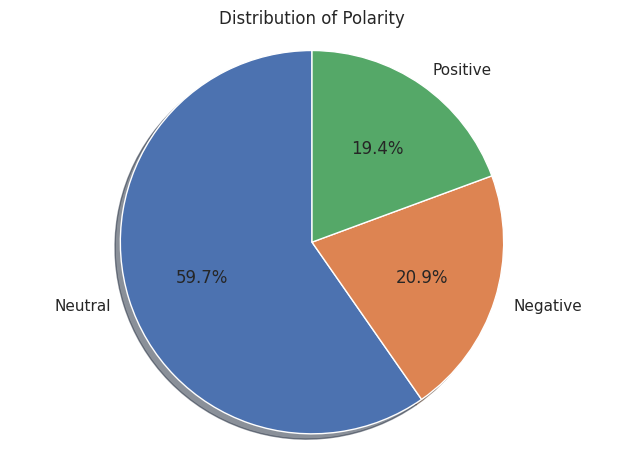

In [19]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Neutral', 'Negative', 'Positive'
total = raw['label'].count()
Neutral = raw['label'][raw['label'] == 'Neutral'].count() / total
Negative = raw['label'][raw['label'] == 'Negative'].count() / total
Positive = raw['label'][raw['label'] == 'Positive'].count() / total
sizes = [Neutral, Negative, Positive]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Polarity', fontsize=12)
plt.set_cmap("gist_rainbow")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of News')

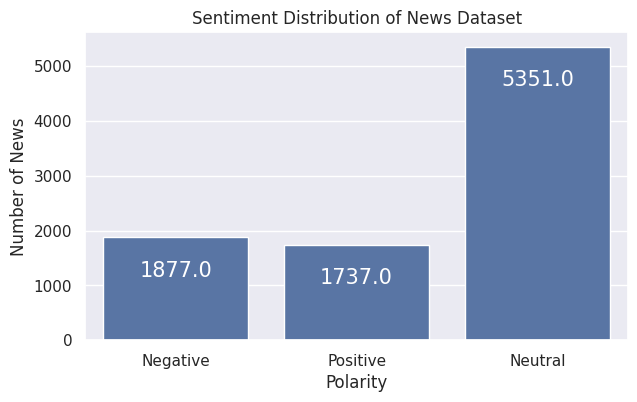

In [20]:
# Configure the plot size
plt.figure(figsize = (7, 4))
sns.set(style='darkgrid')

ax = sns.countplot(x='label', data = raw)
# Increase information on the figure
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=15)
plt.title('Sentiment Distribution of News Dataset')
plt.xlabel('Polarity')
plt.ylabel('Number of News')